In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures


np.random.seed(2)

Read and display data:

In [2]:
train_data = pd.read_csv('./bitrate_prediction/bitrate_train.csv')
test_data = pd.read_csv('./bitrate_prediction/bitrate_test.csv')

In [3]:
report = ProfileReport(train_data)
#report.to_file('./reg_report.html')

In [4]:
test_data.head()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
0,29.9,0.316228,55.0,0.942809,0.0,0.0,0.0,682.8,36.468556,718.0
1,30.0,0.000000,55.0,0.942809,0.0,0.0,0.0,718.0,43.609377,670.9
2,30.0,0.000000,56.0,3.299832,0.0,0.0,0.0,670.9,24.378725,789.8
3,29.9,0.316228,58.4,4.599517,0.0,0.0,0.0,789.8,238.545500,723.2
4,30.0,0.000000,54.7,1.251666,0.0,0.0,0.0,723.2,40.846052,693.6


There are no missing values. All the columns contain numerical data, no encoding is required.

In [5]:
# split predictors and target
X_train, y_train = train_data.drop('target', axis=1), train_data['target']  
X_test, y_test = test_data.drop('target', axis=1), test_data['target']

## Visualization

Visualize data by projecting it to two dimensions with PCA

In [6]:
from sklearn.decomposition import PCA

# scale features before PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

model = PCA(0.95)
projected = model.fit_transform(scaled_data)

Text(0, 0.5, '% Variance')

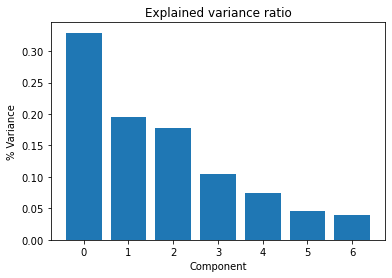

In [7]:
plt.title('Explained variance ratio')
plt.bar(range(len(model.explained_variance_ratio_)), model.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('% Variance')

Projection to the first component captures only 0.3% of information.

Interaction between first two components:

Text(0, 0.5, 'Second component')

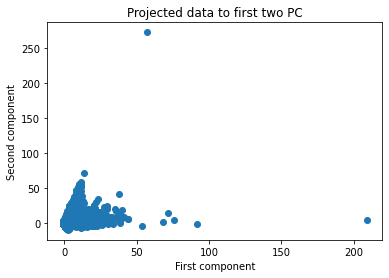

In [8]:
plt.title('Projected data to first two PC')
plt.scatter(projected[:, 0], projected[:, 1])
plt.xlabel('First component')
plt.ylabel('Second component')

The scatter plot shows that some points in the projection are far from others which may imply presence of outliers.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


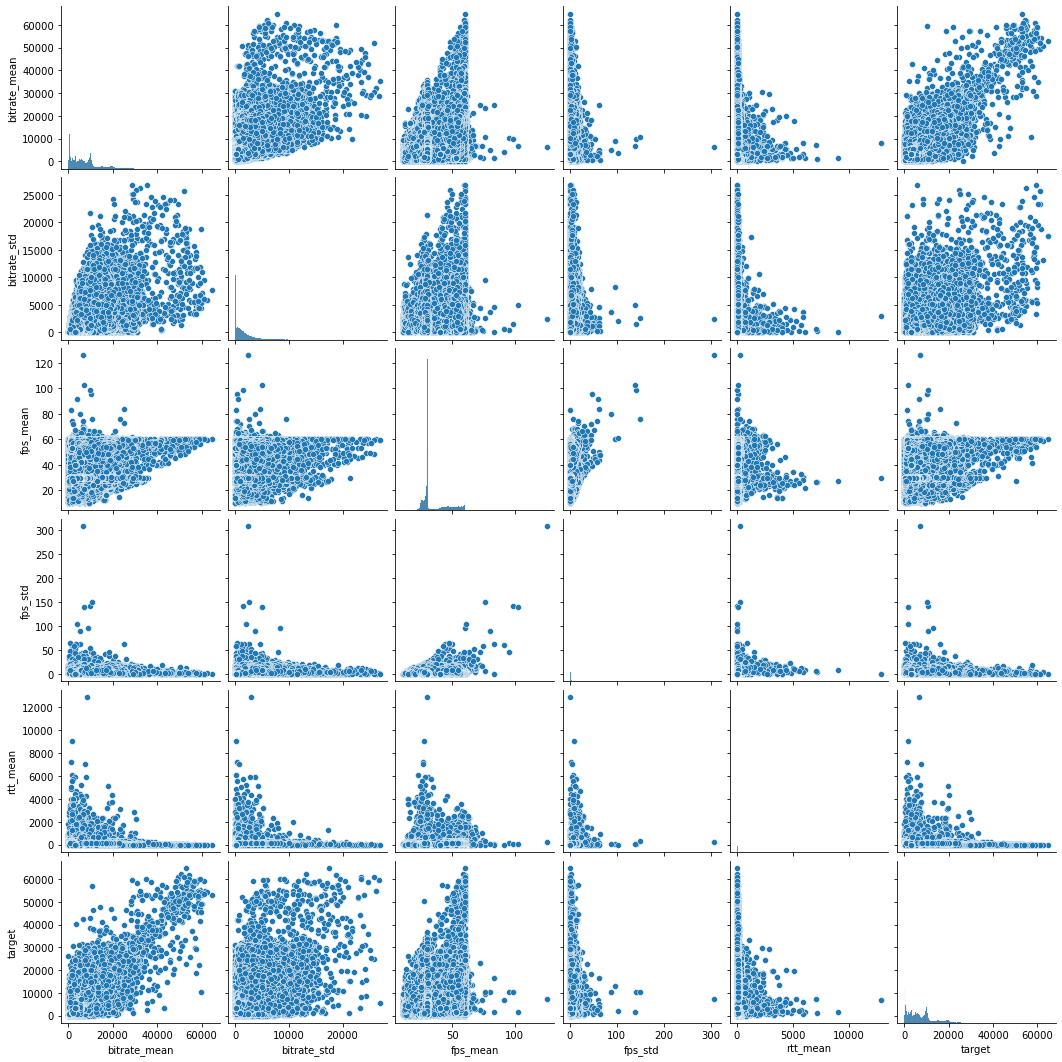

In [86]:
import seaborn as sns

pairplot = sns.pairplot(train_data[['bitrate_mean', 'bitrate_std', 'fps_mean', 'fps_std', 'rtt_mean', 'target']])
#plt.savefig("pairplot.eps", format='eps')

## Feature Selection

Correlation between features:

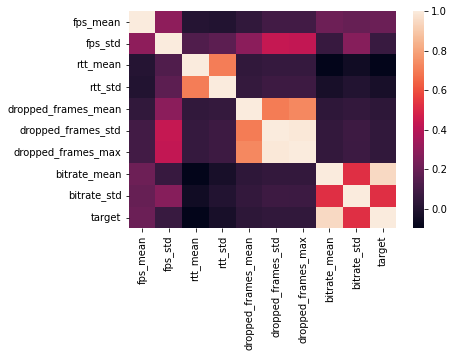

In [87]:
sns.heatmap(train_data.corr())
plt.savefig('corr.eps', format='eps')

Some features are highly correlated with each other and may introduce multicollinearity to the regression problem. There are features with low correlation with target that may be disgarded to reduce the computational cost.

Dropped frame related features have 97% of constant zero values and are not correlated with target, therefore we may consider to exclude them. On the other hand, bitrate_mean and bitrate_std features show high correlation with target as they describe the same variable.

L1 regularized models give sparse coefficients which can be interpreted as the importance of features to the model. Uninformative features get 0 weight score.

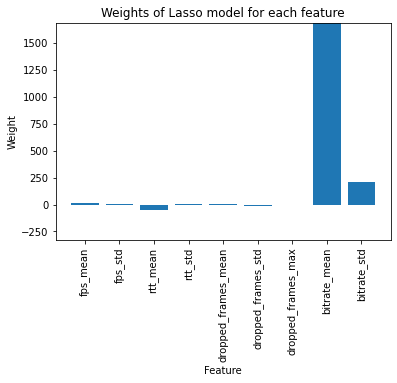

In [11]:
# perform scaling and apply model
feature_selection_pipe = Pipeline([
        ('preprocessing', StandardScaler()), 
        ('model', Lasso())
])

# train Linear Regression with l1 regularization
feature_selection_pipe.fit(X_train, y_train)

cols = X_train.columns
weights = feature_selection_pipe['model'].coef_

# visualize weights
plt.bar(range(len(weights)), weights)
plt.ylim(top=0.3*max(weights))
plt.title('Weights of Lasso model for each feature')
plt.ylabel('Weight')
plt.xlabel('Feature')
_ = plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)

In [12]:
# select columns with non-zero weight score
cols_important = [col for i, col in enumerate(cols) if weights[i]]
print('Selected columns: ', cols_important)
cols_to_exclude = list(set(cols) - set(cols_important))
print('Excluded columns: ', cols_to_exclude)

Selected columns:  ['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'bitrate_mean', 'bitrate_std']
Excluded columns:  ['dropped_frames_max']


The feature 'dropped_frames_max' may be excluded from consideration.

In [13]:
X_train = X_train.drop(cols_to_exclude, axis=1)
X_test = X_test.drop(cols_to_exclude, axis=1)

Further feature selection can be performed by automatic selection methods

In [14]:
# scale data for each feature to have the same contribution
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Text(0, 0.5, 'Mutual information score')

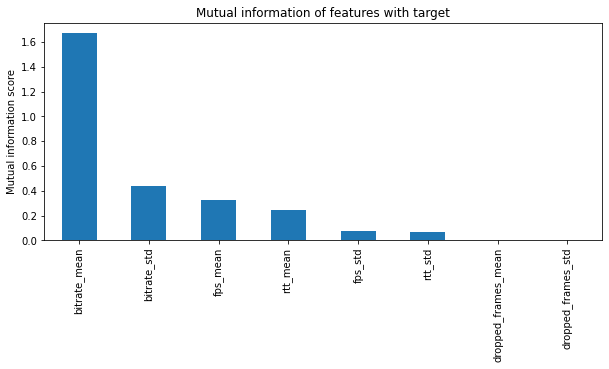

In [15]:
from sklearn.feature_selection import mutual_info_regression

# calculate mutual inf scores
mi = mutual_info_regression(X_train_scaled, y_train)
mutual_info = pd.Series(mi, index=X_train.columns)

# visualize
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 4))
plt.title('Mutual information of features with target')
plt.ylabel('Mutual information score')

Select features based on their mutual information score with target:

In [16]:
from sklearn.feature_selection import SelectKBest

mi_selector = SelectKBest(mutual_info_regression, k=6)
mi_selector.fit(X_train_scaled, y_train)
mi_selected_feats = X_train.columns[mi_selector.get_support()]
print('Selected features based on mutual information: ', mi_selected_feats.tolist())

Selected features based on mutual information:  ['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'bitrate_mean', 'bitrate_std']


Feature importance to the model can be obtained by comparing performance of model before and after removing this feature from the data.

In [17]:
from sklearn.feature_selection import RFECV, RFE

rfe = RFE(
    estimator=Lasso(),
    step=1,
    n_features_to_select=2
)

rfe.fit(X_train_scaled, y_train)

print('Ranked features: ')
print(pd.Series(X_train.columns[rfe.ranking_.argsort()]))

Ranked features: 
0           bitrate_mean
1            bitrate_std
2               rtt_mean
3               fps_mean
4     dropped_frames_std
5                rtt_std
6                fps_std
7    dropped_frames_mean
dtype: object


This process can be done iteratively with cross validation considering every combination of features and saving the best match.

In [18]:
from sklearn.model_selection import StratifiedKFold

rfecv = RFECV(
    estimator=Lasso(),
    step=2,
    cv=5,
    min_features_to_select=2
)
rfecv.fit(X_train_scaled, y_train)
print('Selected features: ', X_train.columns[rfecv.support_].tolist())
print('Dropped features: ', set(X_train.columns) - set(X_train.columns[rfecv.support_]))

Selected features:  ['fps_mean', 'rtt_mean', 'bitrate_mean', 'bitrate_std']
Dropped features:  {'rtt_std', 'dropped_frames_std', 'fps_std', 'dropped_frames_mean'}


All methods show that dropped_frames features can be excluded without major performance drop. Besides, these columns are mostly zeros

In [19]:
selected_cols = X_train.columns[rfecv.support_].tolist()
print('Final selected columns: ', selected_cols)

Final selected columns:  ['fps_mean', 'rtt_mean', 'bitrate_mean', 'bitrate_std']


## Model

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred):
    """
    Root of Mean Squared Error
    :param y_true: ground truth values
    :param y_pred: predicted values
    :return: rmse score
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def get_regr_metrics(y_true, y_pred):
    """
    Calculation of regression metrics
    :param y_true: ground truth values
    :param y_pred: predicted values
    :return: pd.Series of metric values
    """
    metrics = {'MSE': mean_squared_error(y_true, y_pred), 
              'RMSE':rmse(y_true, y_pred),
              'MAE':mean_absolute_error(y_true, y_pred),
               'R2':r2_score(y_true, y_pred)}
    
    return pd.Series(metrics)

In [53]:
def fit_predict(model, X_train, y_train, X_test):
    """
    Function to perform train and predict
    :param model: model to use
    :param X_train: train data
    :param y_train: target
    :param X_test: test data
    :return: predicted values for train and test data
    """
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)    
    return y_pred_train, y_pred_test

def print_metrics(y_train, y_pred_train, y_test, y_pred_test):
    """
    Function to get train and test metrics
    :param y_train: ground truth for train data
    :param y_pred_train: predicted values for train data
    :param y_test: ground truth for test data
    :param y_pred_test: predicted values for test data
    :return: DataFrame with train and test metrics
    """
    train_metrics = get_regr_metrics(y_train, y_pred_train)
    test_metrics = get_regr_metrics(y_test, y_pred_test)
    return pd.concat([train_metrics, test_metrics], axis=1, keys=['train', 'test']).round(3)

Baseline is training linear regression over all initial features:

In [54]:
linear_regr = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('model', LinearRegression())
])

y_train_pred, y_test_pred = fit_predict(linear_regr, X_train, y_train, X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred) 

,train,test
MSE,3902002.638,3798384.504
RMSE,1975.349,1948.944
MAE,1096.649,1076.804
R2,0.894,0.893


Traininng linear model on selected features:

In [55]:
y_train_pred, y_test_pred = fit_predict(linear_regr, X_train[selected_cols], y_train, X_test[selected_cols])
linear_metrics = print_metrics(y_train, y_train_pred, y_test, y_test_pred) 
linear_metrics

,train,test
MSE,3902238.448,3798951.651
RMSE,1975.408,1949.090
MAE,1096.874,1077.001
R2,0.894,0.893


Performance of the model did not drop much, but now there are less number of predictors.

 - Models with regularization

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

regr_lasso = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('model', Lasso())
])

# find the regularization coefficient on cross validation
search_tool = RandomizedSearchCV(regr_lasso, {'model__alpha':uniform(loc=0, scale=1)}, 
                                 scoring='r2')
search_tool.fit(X_train[selected_cols], y_train)
print('Best parameter value alpha = ', search_tool.best_params_['model__alpha'], '\n')
print('Best score: ', search_tool.best_score_)

# evaluate performance on the whole train set and on the test set
y_train_pred, y_test_pred = fit_predict(search_tool.best_estimator_, X_train[selected_cols], y_train, X_test[selected_cols])
lasso_metrics = print_metrics(y_train, y_train_pred, y_test, y_test_pred) 
lasso_metrics

Best parameter value alpha =  0.9984387854569058 

Best score:  0.8922869043724264


,train,test
MSE,3902241.218,3798980.510
RMSE,1975.409,1949.097
MAE,1097.097,1077.203
R2,0.894,0.893


In [57]:
regr_ridge = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('model', Ridge())
])

# find the regularization coefficient on cross validation
search_tool = RandomizedSearchCV(regr_ridge, {'model__alpha':uniform(loc=0, scale=1)}, 
                                 scoring='r2')
search_tool.fit(X_train[selected_cols], y_train)
print('Best parameter value alpha = ', search_tool.best_params_['model__alpha'], '\n')
print('Best score: ', search_tool.best_score_)

# evaluate performance on the whole train set and on the test set
y_train_pred, y_test_pred = fit_predict(search_tool.best_estimator_, X_train[selected_cols], y_train, X_test[selected_cols])
ridge_metrics = print_metrics(y_train, y_train_pred, y_test, y_test_pred) 
ridge_metrics

Best parameter value alpha =  0.02438908113881455 

Best score:  0.8922867242168045


,train,test
MSE,3902238.448,3798951.661
RMSE,1975.408,1949.090
MAE,1096.874,1077.001
R2,0.894,0.893


Performance is similar for both methods on regularizing Linear Regression.

- Polynomial Features

In [58]:
from sklearn.preprocessing import PolynomialFeatures

reg_poly_ridge = Pipeline([
    ('poly', PolynomialFeatures()), 
    ('preprocessing', StandardScaler()), 
    ('model', Ridge())
])

# find the regularization coefficient and degree of polynomial on cross validation
search_tool = RandomizedSearchCV(reg_poly_ridge, {'model__alpha':uniform(loc=0, scale=1),
                                                      'poly__degree':[1, 2, 3], 
                                                      'poly__interaction_only':[True, False]}, 
                                 scoring='r2')
search_tool.fit(X_train[selected_cols], y_train)
print('Best parameter value alpha = ', search_tool.best_params_['model__alpha'], '\n')
print('Degree: ', search_tool.best_params_['poly__degree'], '\n')
print('Interaction only: ', search_tool.best_params_['poly__interaction_only'], '\n')
print('Best score: ', search_tool.best_score_)

# evaluate performance on the whole train set and on the test set
y_train_pred, y_test_pred = fit_predict(search_tool.best_estimator_, X_train[selected_cols],
                                        y_train, X_test[selected_cols])
poly_metrics = print_metrics(y_train, y_train_pred, y_test, y_test_pred) 
poly_metrics

Best parameter value alpha =  0.9726478075258543 

Degree:  3 

Interaction only:  False 

Best score:  0.8933336977201305


,train,test
MSE,3840784.123,3778995.732
RMSE,1959.792,1943.964
MAE,1064.711,1051.334
R2,0.896,0.894


Visualize performance on train and test set:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


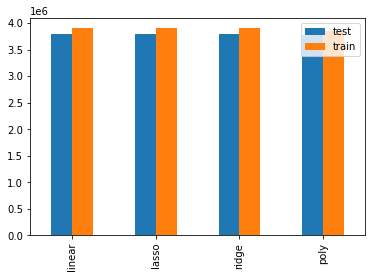

In [84]:
metric = 'MSE'
mse_metrics_test = {'linear':linear_metrics['test'][metric], 
               'lasso':lasso_metrics['test'][metric], 
               'ridge':ridge_metrics['test'][metric], 
               'poly':poly_metrics['test'][metric]}
mse_metrics_train = {'linear':linear_metrics['train'][metric], 
               'lasso':lasso_metrics['train'][metric], 
               'ridge':ridge_metrics['train'][metric], 
               'poly':poly_metrics['train'][metric]}
mse_metrics = pd.DataFrame([mse_metrics_test, mse_metrics_train], index=['test', 'train'])
mse_metrics.T.plot.bar()
plt.title('Performance of models')
plt.ylabel('MSE')
#plt.savefig('regr_mse.eps', format='eps')

The models are not overfitted or underffitted, the performance on train and test set is comparable

### Outlier detection

Linear models are highly affected by the outliers. Interquartile range method can be used to detect them:

In [44]:
# compute interquartile range
iqr = X_train[selected_cols].quantile(0.75) - X_train[selected_cols].quantile(0.25)
# upper bound for distribution
up_bound = X_train[selected_cols].quantile(0.75) + iqr * 1.5
# lower bound for distribution
low_bound = X_train[selected_cols].quantile(0.25) - iqr * 1.5
# select outliers which are higher than upper bound or lower than lower bound
outliers_mask = ((X_train[selected_cols] > up_bound) | (X_train[selected_cols] < low_bound)).sum(axis=1) > 0
X_train_clean = X_train[~outliers_mask][selected_cols].copy()
y_train_clean = y_train[~outliers_mask].copy()

print('Percentage of outliers: ', 1 - X_train_clean.shape[0] / X_train.shape[0])

Percentage of outliers:  0.13811108091636082


Data distribution and paired scatter plots after removing outliers:

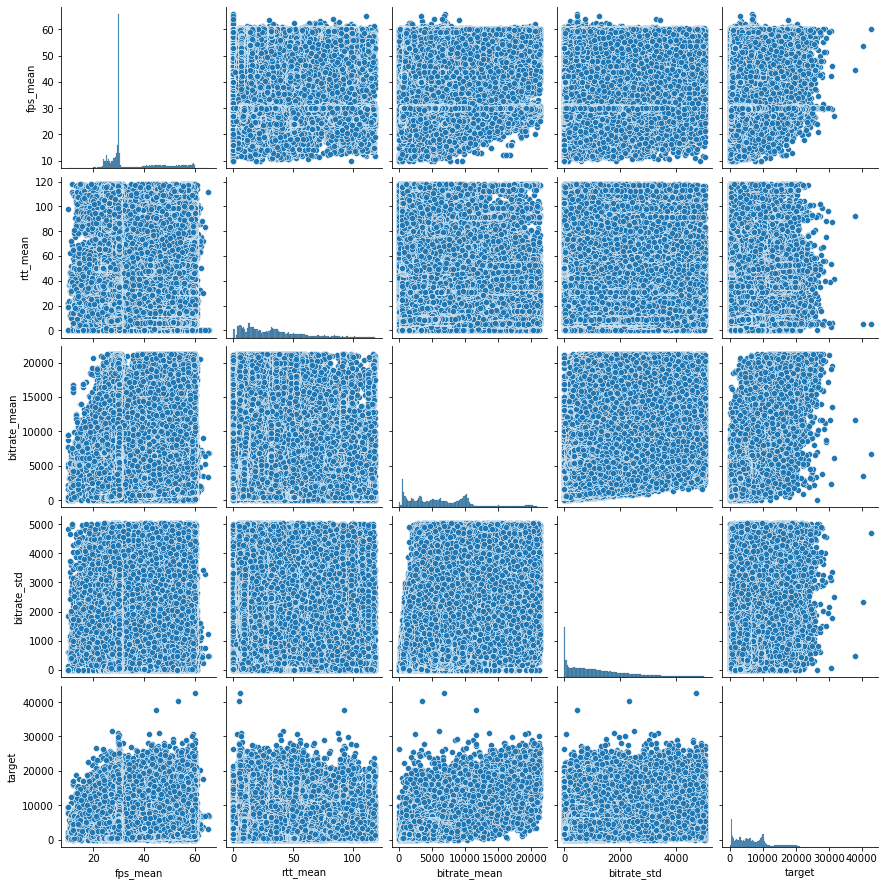

In [45]:
sns.pairplot(X_train_clean.assign(target=y_train_clean))

New selected train data is less structured

In [46]:
search_tool.fit(X_train_clean, y_train_clean)
print('Best parameter value alpha = ', search_tool.best_params_['model__alpha'], '\n')
print('Best score: ', search_tool.best_score_)

# evaluate performance on the whole train set and on the test set
y_train_pred, y_test_pred = fit_predict(search_tool.best_estimator_, X_train_clean,
                                        y_train_clean, X_test[selected_cols])
print_metrics(y_train_clean, y_train_pred, y_test, y_test_pred) 

Best parameter value alpha =  0.5647099979286277 

Best score:  0.8973731038546591


,train,test
MSE,2718701.818,3.036973e+11
RMSE,1648.849,5.510874e+05
MAE,924.089,8.010251e+03
R2,0.899,-8.515309e+03


Removing outliers hurt performance of a model, indicating that useful information was excluded. The distribution of data on train and on test set is now different leading to overfit on train data. 

As another approach density based methods can be applied:

In [47]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train[selected_cols])
outliers_mask = yhat == -1

vals, counts = np.unique(yhat, return_counts=True)
print('Percentage of outliers: ', counts[0] / train_data.shape[0])

Percentage of outliers:  0.02093815382261141


In [48]:
X_train_clean = X_train[selected_cols][~outliers_mask]
y_train_clean = y_train[~outliers_mask]

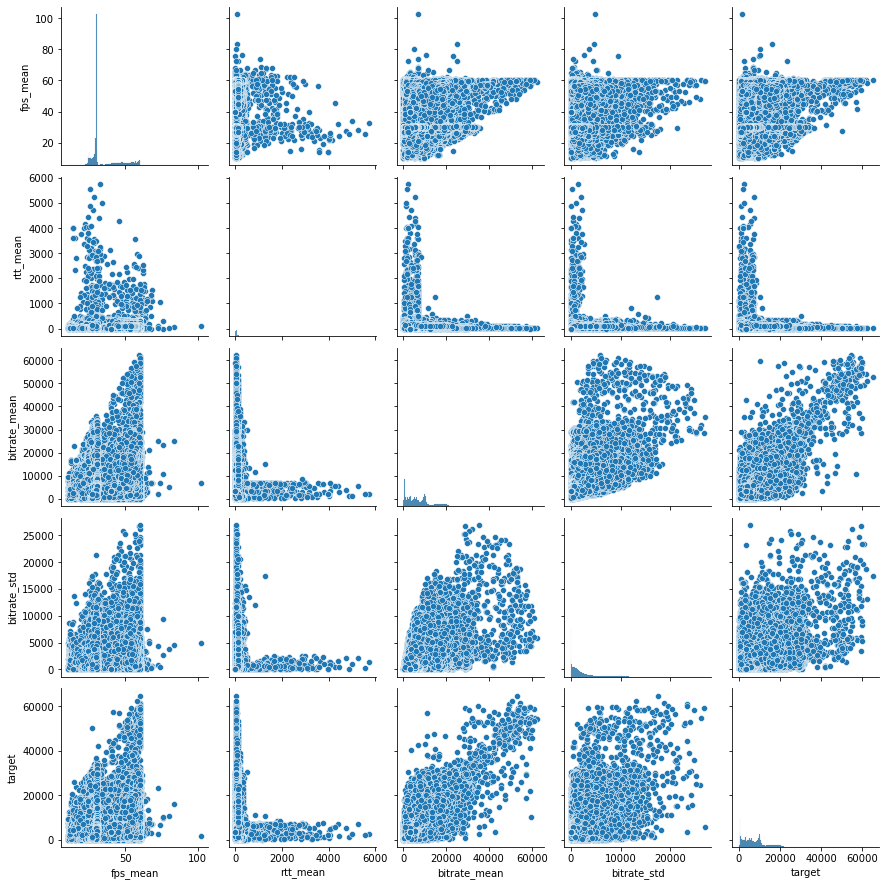

In [49]:
sns.pairplot(X_train_clean.assign(target=y_train_clean))

Train model on data without outliers:

In [51]:
search_tool = RandomizedSearchCV(reg_poly_ridge, {'model__alpha':uniform(loc=0, scale=1),
                                                      'poly__degree':[1, 2, 3], 
                                                      'poly__interaction_only':[True, False]}, 
                                 scoring='r2')
search_tool.fit(X_train_clean, y_train_clean)
print('Best parameter value alpha = ', search_tool.best_params_['model__alpha'], '\n')
print('Degree: ', search_tool.best_params_['poly__degree'], '\n')
print('Best score: ', search_tool.best_score_)

# evaluate performance on the whole train set and on the test set
y_train_pred, y_test_pred = fit_predict(search_tool.best_estimator_, X_train_clean,
                                        y_train_clean, X_test[selected_cols])
print_metrics(y_train_clean, y_train_pred, y_test, y_test_pred) 

Best parameter value alpha =  0.9756801621502424 

Degree:  3 

Best score:  0.8933356609207024


,train,test
MSE,3840407.244,3782443.232
RMSE,1959.696,1944.850
MAE,1066.571,1051.732
R2,0.896,0.894


Outlier detection did not improve much the performance of model